# Optimizer Benchmark

This notebook compares different optimization solvers from `furax_cs.optim` on the Rosenbrock function.

## Test Matrix

| Solver Category | Configurations | Total Runs |
|-----------------|----------------|------------|
| Adam/SGD/Ada | 4 solvers x 2 lr x 2 precond | 16 |
| Active Set v1 | 4 solvers x 3 lr x 2 linesearch | 24 |
| Active Set v2 | 4 solvers x 3 lr x 2 linesearch | 24 |
| LBFGS | 2 linesearch x 2 precond | 4 |
| **Total** | | **68** |

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from furax_cs.optim import minimize

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

W0123 17:10:34.574353   31328 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0123 17:10:34.581748   31253 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


f(x*) = 7.29e+06
f(x0) = 2.06e+03


100.00%|██████████| [00:00<00:00, 1994.38%/s]


Optimized f(x) = 1.18e+03


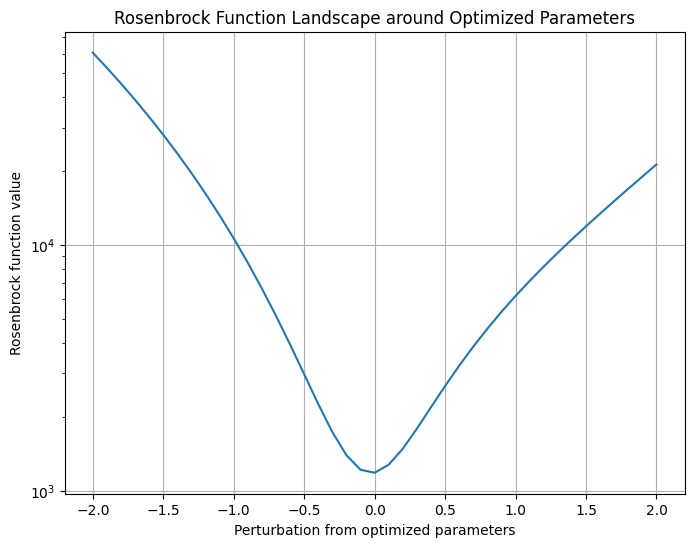

Smallest eigenvalue: 17.231431250435254
Associated vector: [-5.87074112e-05  1.32507283e-04  4.90897627e-04 -1.21946326e-03
 -4.58686639e-03  1.14099154e-02  4.29246869e-02 -1.06786199e-01
 -4.03218167e-01  9.07753443e-01]


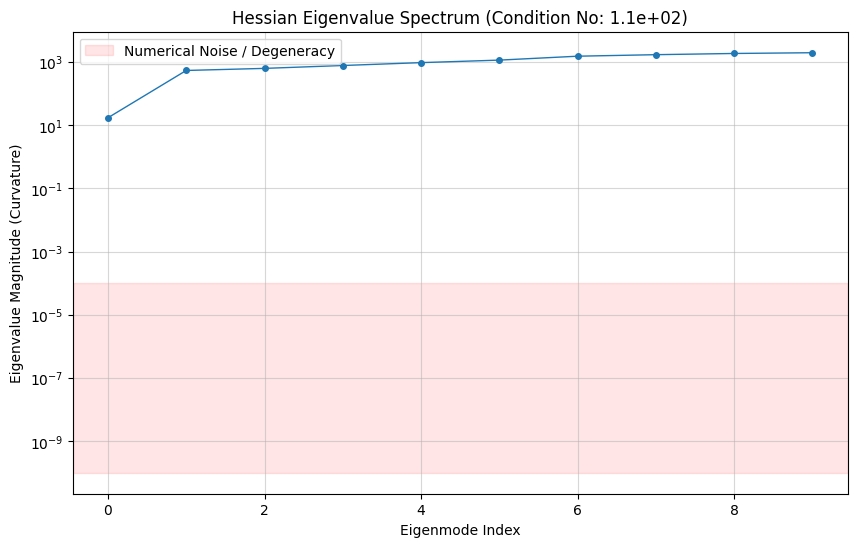

In [2]:
def rosenbrock(x):
    """Rosenbrock function.

    f(x) = sum(100*(x[i+1] - x[i]^2)^2 + (1 - x[i])^2)

    Minimum: x* = [1, 1, ..., 1], f(x*) = 0
    """
    return jnp.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)


# Test the function
n_dims = 10
x_opt = jnp.ones(n_dims) * 10
print(f"f(x*) = {rosenbrock(x_opt):.2e}")

# Classic starting point
x0 = jnp.array([-1.2, 1.0] * (n_dims // 2))
print(f"f(x0) = {rosenbrock(x0):.2e}")


param, state = minimize(
    rosenbrock,
    x0,
    solver_name="adam",
    max_iter=200,
    atol=1e-15,
    rtol=1e-15,
    lower_bound=-5.0,
    upper_bound=5.0,
)

print(f"Optimized f(x) = {rosenbrock(param):.2e}")

perturb_scale = 0.1
steps = jnp.arange(-20, 21, 1) * perturb_scale
grid_vals = steps.reshape(-1, 1) + param.reshape(1, -1)

vals = jax.vmap(rosenbrock)(grid_vals)

plt.figure(figsize=(8, 6))
plt.plot(steps, vals)
plt.yscale("log")
plt.xlabel("Perturbation from optimized parameters")
plt.ylabel("Rosenbrock function value")
plt.title("Rosenbrock Function Landscape around Optimized Parameters")
plt.grid()
plt.show()

# 2. Materialize the full Hessian Matrix
H = jax.hessian(rosenbrock)(param)

# 3. Compute Eigenvalues/Vectors
# eigh guarantees real eigenvalues for symmetric matrices
eigvals, eigvecs = jnp.linalg.eigh(H)

# eigvals are sorted ascending.
# eigvecs[:, i] is the vector corresponding to eigvals[i]
print("Smallest eigenvalue:", eigvals[0])
print("Associated vector:", eigvecs[:, 0])


# Assuming 'eigvals' comes from jnp.linalg.eigh(H)
# Sort them just in case (eigh usually sorts, but good practice)
eigvals_sorted = jnp.sort(eigvals)

plt.figure(figsize=(10, 6))
plt.plot(eigvals_sorted, "o-", markersize=4, linewidth=1)
plt.yscale("log")  # CRITICAL: Use log scale to see the tiny values
plt.title(f"Hessian Eigenvalue Spectrum (Condition No: {eigvals_sorted[-1]/eigvals_sorted[0]:.1e})")
plt.ylabel("Eigenvalue Magnitude (Curvature)")
plt.xlabel("Eigenmode Index")
plt.grid(True, which="both", ls="-", alpha=0.5)

# Add a "Dangerous Flatness" zone
plt.axhspan(1e-10, 1e-4, color="red", alpha=0.1, label="Numerical Noise / Degeneracy")
plt.legend()
plt.show()

In [13]:
eigvals

Array([  35.178079  ,  839.05471775,  946.67697787, 1124.11267378,
       1344.27794419, 1591.60078999, 2023.58745027, 2241.40393647,
       2429.79396429, 2553.55842245], dtype=float64)

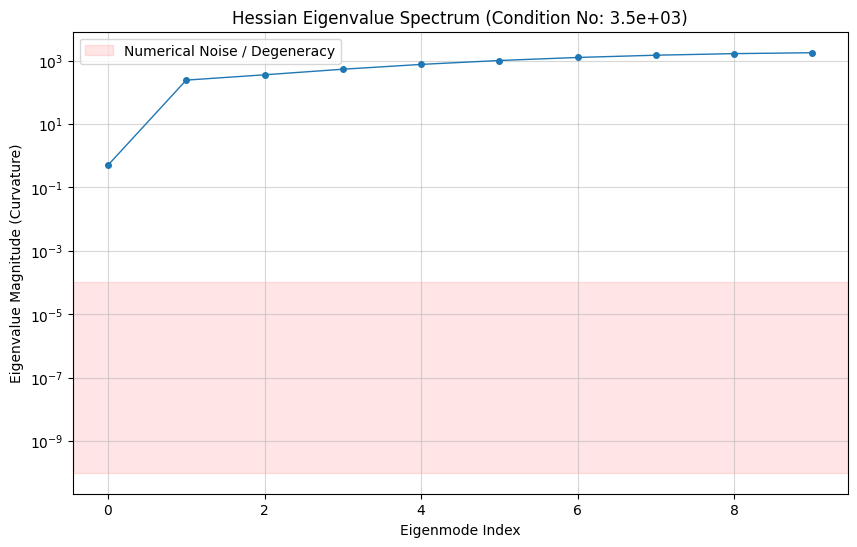

In [36]:
import matplotlib.pyplot as plt

# Assuming 'eigvals' comes from jnp.linalg.eigh(H)
# Sort them just in case (eigh usually sorts, but good practice)
eigvals_sorted = jnp.sort(eigvals)

plt.figure(figsize=(10, 6))
plt.plot(eigvals_sorted, "o-", markersize=4, linewidth=1)
plt.yscale("log")  # CRITICAL: Use log scale to see the tiny values
plt.title(f"Hessian Eigenvalue Spectrum (Condition No: {eigvals_sorted[-1]/eigvals_sorted[0]:.1e})")
plt.ylabel("Eigenvalue Magnitude (Curvature)")
plt.xlabel("Eigenmode Index")
plt.grid(True, which="both", ls="-", alpha=0.5)

# Add a "Dangerous Flatness" zone
plt.axhspan(1e-10, 1e-4, color="red", alpha=0.1, label="Numerical Noise / Degeneracy")
plt.legend()
plt.show()

In [32]:
H

Array([[  2.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 202.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 202., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 202.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 202.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 200.]], dtype=float64)

In [13]:
hessian = jax.hessian(rosenbrock)(param)
hessian @ jnp.ones_like(param)

Array([ 402.,  202.,  202.,  202.,  202.,  202.,  202.,  202.,  202.,
       -200.], dtype=float64)

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh


# 1. Define your Function (Rosenbrock)
def rosenbrock(x):
    return jnp.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)


# 2. Define the Hessian-Vector Product (HVP)
# This computes H*v using forward-over-reverse auto-diff
@jax.jit
def hvp(f, primals, tangents):
    return jax.jvp(jax.grad(f), (primals,), (tangents,))[1]


# 3. Wrapper for SciPy's LinearOperator
def get_eigenvalues(func, params, k=1):
    """
    Computes the k smallest and k largest eigenvalues of the Hessian
    at 'params' without materializing the matrix.
    """
    N = params.shape[0]

    # Define the matrix-vector multiplication for SciPy
    def matvec(v):
        v_jax = jnp.array(v)
        # hvp requires the function, the point (params), and the vector (v)
        return np.array(hvp(func, params, v_jax))

    # Create the LinearOperator
    A = LinearOperator((N, N), matvec=matvec)

    # Compute Smallest Eigenvalue (Algebraic) -> Checks for negative curvature
    evals_small, evecs_small = eigsh(A, k=k, which="SA", tol=1e-5)

    # Compute Smallest Magnitude -> Checks for flatness/degeneracy
    evals_flat, evecs_flat = eigsh(A, k=k, which="SM", tol=1e-5)

    # Compute Largest Eigenvalue -> Used for Condition Number
    evals_large, evecs_large = eigsh(A, k=k, which="LA", tol=1e-5)

    return {
        "min_algebraic": (evals_small, evecs_small),  # Most negative (or smallest positive)
        "min_magnitude": (evals_flat, evecs_flat),  # Closest to zero
        "max_algebraic": (evals_large, evecs_large),  # Largest positive
    }


# --- USAGE EXAMPLE ---
# Assume 'param' is your optimized solution from the previous step
# param = ... (your optimized array)

results = get_eigenvalues(rosenbrock, param, k=1)

lambda_min = results["min_algebraic"][0][0]
lambda_flat = results["min_magnitude"][0][0]  # Should be same as min if positive definite
lambda_max = results["max_algebraic"][0][0]

print(f"Smallest Eigenvalue: {lambda_min:.4e}")
print(f"Largest Eigenvalue:  {lambda_max:.4e}")
print(f"Condition Number:    {abs(lambda_max / lambda_flat):.4e}")

TypeError: Error interpreting argument to <function hvp at 0x7fbc453bb420> as an abstract array. The problematic value is of type <class 'function'> and was passed to the function at path f.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [ ]:
# Define all benchmark configurations
configs = []

# Adam/SGD/Ada (16 runs): 4 solvers x 2 lr x 2 precond
# for solver in ["adam", "sgd", "adabelief", "adaw"]:
#    for lr in [1e-3, 1e-2]:
#        for precond in [False, True]:
#            configs.append({
#                "name": f"{solver}_lr{lr}_{'cond' if precond else 'nocond'}",
#                "solver": solver,
#                "lr": lr,
#                "precond": precond,
#                "category": "Adam/SGD"
#            })
#
# Active Set v1 (24 runs): 4 solvers x 3 lr x 2 linesearch
for solver in ["active_set", "active_set_sgd", "active_set_adabelief", "active_set_adaw"]:
    for lr in [1e-3, 1e-2, 1.0]:
        for ls in ["backtracking", "zoom"]:
            configs.append(
                {
                    "name": f"{solver}_lr{lr}_{ls[:2]}",
                    "solver": solver,
                    "lr": lr,
                    "ls": ls,
                    "precond": False,
                    "category": "Active Set v1",
                }
            )

# Active Set v2 (24 runs): 4 solvers x 3 lr x 2 linesearch
# for solver in ["active_set_v2", "active_set_v2_sgd", "active_set_v2_adabelief", "active_set_v2_adaw"]:
#    for lr in [1e-3, 1e-2, 1.0]:
#        for ls in ["backtracking", "zoom"]:
#            configs.append({
#                "name": f"{solver}_lr{lr}_{ls[:2]}",
#                "solver": solver,
#                "lr": lr,
#                "ls": ls,
#                "precond": False,
#                "category": "Active Set v2"
#            })

# LBFGS (4 runs): 2 linesearch x 2 precond
# for ls_type, solver in [("backtracking", "optax_lbfgs"), ("zoom", "optax_lbfgs")]:
#    for precond in [False, True]:
#        configs.append({
#            "name": f"lbfgs_{ls_type[:2]}_{'cond' if precond else 'nocond'}",
#            "solver": solver,
#            "precond": precond,
#            "category": "LBFGS"
#        })#

## Scipy (2 runs)
# for solver in ["scipy_tnc", "scipy_cobyqa"]:
#    configs.append({
#        "name": solver,
#        "solver": solver,
#        "precond": False,
#        "category": "Scipy"
#    })

print(f"Total configurations: {len(configs)}")

Total configurations: 70


In [4]:
def run_benchmark(config, x0, max_iter=2000, lower_bound=-5.0, upper_bound=10.0):
    """Run a single benchmark configuration."""
    solver_opts = {}
    if "lr" in config:
        solver_opts["learning_rate"] = config["lr"]
    if "ls" in config:
        solver_opts["linesearch"] = config["ls"]

    try:
        xs, state = minimize(
            rosenbrock,
            x0,
            solver_name=config["solver"],
            solver_options=solver_opts,
            precondition=config.get("precond", False),
            lower_bound=lower_bound,
            upper_bound=upper_bound,
            max_iter=max_iter,
            atol=1e-15,
            rtol=1e-12,
        )

        final_loss = float(rosenbrock(xs))
        distance = float(jnp.linalg.norm(xs - 1.0))
        steps = int(state.iter_num)
        converged = final_loss < 1e-10
        error = None
    except Exception as e:
        final_loss = float("inf")
        distance = float("inf")
        steps = -1
        converged = False
        error = str(e)[:50]

    return {
        "name": config["name"],
        "category": config["category"],
        "steps": steps,
        "final_loss": final_loss,
        "distance_to_opt": distance,
        "converged": converged,
        "error": error,
    }

In [5]:
# Run all benchmarks
results = []

for i, config in enumerate(configs):
    print(f"Running {i+1}/{len(configs)}: {config['name']}...", end=" ")
    result = run_benchmark(config, x0)
    results.append(result)

    if result["error"]:
        print(f"ERROR: {result['error']}")
    else:
        print(
            f"steps={result['steps']}, loss={result['final_loss']:.2e}, dist={result['distance_to_opt']:.2e}"
        )

print("\nDone!")

Running 1/70: adam_lr0.001_nocond... 

100.00%|██████████| [00:00<00:00, 476.21%/s]


steps=2000, loss=5.65e+06, dist=6.61e+00
Running 2/70: adam_lr0.001_cond... 

100.00%|██████████| [00:00<00:00, 625.71%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 3/70: adam_lr0.01_nocond... 

100.00%|██████████| [00:00<00:00, 546.04%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 4/70: adam_lr0.01_cond... 

100.00%|██████████| [00:00<00:00, 2284.43%/s]


steps=488, loss=3.09e+06, dist=1.30e+01
Running 5/70: sgd_lr0.001_nocond... 

100.00%|██████████| [00:00<00:00, 833.87%/s]


steps=692, loss=3.09e+06, dist=1.30e+01
Running 6/70: sgd_lr0.001_cond... 

100.00%|██████████| [00:00<00:00, 306.53%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 7/70: sgd_lr0.01_nocond... 

100.00%|██████████| [00:00<00:00, 830.25%/s]


steps=692, loss=3.09e+06, dist=1.30e+01
Running 8/70: sgd_lr0.01_cond... 

100.00%|██████████| [00:00<00:00, 290.09%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 9/70: adabelief_lr0.001_nocond... 

100.00%|██████████| [00:00<00:00, 329.96%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 10/70: adabelief_lr0.001_cond... 

100.00%|██████████| [00:00<00:00, 615.16%/s]


steps=1280, loss=3.09e+06, dist=1.30e+01
Running 11/70: adabelief_lr0.01_nocond... 

100.00%|██████████| [00:00<00:00, 501.87%/s]


steps=1718, loss=3.09e+06, dist=1.30e+01
Running 12/70: adabelief_lr0.01_cond... 

100.00%|██████████| [00:00<00:00, 1663.88%/s]


steps=488, loss=3.09e+06, dist=1.30e+01
Running 13/70: adaw_lr0.001_nocond... 

100.00%|██████████| [00:00<00:00, 371.64%/s]


steps=2000, loss=5.65e+06, dist=6.61e+00
Running 14/70: adaw_lr0.001_cond... 

100.00%|██████████| [00:00<00:00, 447.37%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 15/70: adaw_lr0.01_nocond... 

100.00%|██████████| [00:00<00:00, 423.62%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 16/70: adaw_lr0.01_cond... 

100.00%|██████████| [00:00<00:00, 390.73%/s]


steps=2000, loss=3.09e+06, dist=1.30e+01
Running 17/70: active_set_lr0.001_ba... 

100.00%|██████████| [00:00<00:00, 14680.28%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 18/70: active_set_lr0.001_zo... 

100.00%|██████████| [00:00<00:00, 963.83%/s]


steps=306, loss=3.10e+06, dist=1.57e+01
Running 19/70: active_set_lr0.01_ba... 

100.00%|██████████| [00:00<00:00, 14195.36%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 20/70: active_set_lr0.01_zo... 

100.00%|██████████| [00:00<00:00, 1163.71%/s]


steps=306, loss=3.10e+06, dist=1.57e+01
Running 21/70: active_set_lr1.0_ba... 

100.00%|██████████| [00:00<00:00, 15488.00%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 22/70: active_set_lr1.0_zo... 

100.00%|██████████| [00:00<00:00, 943.88%/s]


steps=306, loss=3.10e+06, dist=1.57e+01
Running 23/70: active_set_sgd_lr0.001_ba... 

100.00%|██████████| [00:00<00:00, 2004.28%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 24/70: active_set_sgd_lr0.001_zo... 

100.00%|██████████| [00:00<00:00, 1905.31%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 25/70: active_set_sgd_lr0.01_ba... 

100.00%|██████████| [00:00<00:00, 1811.92%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 26/70: active_set_sgd_lr0.01_zo... 

100.00%|██████████| [00:00<00:00, 1967.07%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 27/70: active_set_sgd_lr1.0_ba... 

100.00%|██████████| [00:00<00:00, 1896.83%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 28/70: active_set_sgd_lr1.0_zo... 

100.00%|██████████| [00:00<00:00, 2140.39%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 29/70: active_set_adabelief_lr0.001_ba... 

100.00%|██████████| [00:00<00:00, 8536.46%/s]


steps=11, loss=3.10e+06, dist=1.65e+01
Running 30/70: active_set_adabelief_lr0.001_zo... 

100.00%|██████████| [00:00<00:00, 955.49%/s]


steps=324, loss=3.09e+06, dist=1.64e+01
Running 31/70: active_set_adabelief_lr0.01_ba... 

100.00%|██████████| [00:00<00:00, 8080.27%/s]


steps=11, loss=3.10e+06, dist=1.65e+01
Running 32/70: active_set_adabelief_lr0.01_zo... 

100.00%|██████████| [00:00<00:00, 896.12%/s]


steps=324, loss=3.09e+06, dist=1.64e+01
Running 33/70: active_set_adabelief_lr1.0_ba... 

100.00%|██████████| [00:00<00:00, 8327.15%/s]


steps=11, loss=3.10e+06, dist=1.65e+01
Running 34/70: active_set_adabelief_lr1.0_zo... 

100.00%|██████████| [00:00<00:00, 966.37%/s]


steps=324, loss=3.09e+06, dist=1.64e+01
Running 35/70: active_set_adaw_lr0.001_ba... 

100.00%|██████████| [00:00<00:00, 14575.70%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 36/70: active_set_adaw_lr0.001_zo... 

100.00%|██████████| [00:00<00:00, 11449.21%/s]


steps=20, loss=3.10e+06, dist=1.54e+01
Running 37/70: active_set_adaw_lr0.01_ba... 

100.00%|██████████| [00:00<00:00, 14684.91%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 38/70: active_set_adaw_lr0.01_zo... 

100.00%|██████████| [00:00<00:00, 9808.25%/s]


steps=20, loss=3.10e+06, dist=1.54e+01
Running 39/70: active_set_adaw_lr1.0_ba... 

100.00%|██████████| [00:00<00:00, 13707.32%/s]


steps=11, loss=3.10e+06, dist=1.57e+01
Running 40/70: active_set_adaw_lr1.0_zo... 

100.00%|██████████| [00:00<00:00, 11343.31%/s]


steps=20, loss=3.10e+06, dist=1.54e+01
Running 41/70: active_set_v2_lr0.001_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 10553.57%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 42/70: active_set_v2_lr0.001_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 940.62%/s]


steps=271, loss=3.09e+06, dist=1.66e+01
Running 43/70: active_set_v2_lr0.01_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 10691.85%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 44/70: active_set_v2_lr0.01_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 984.29%/s]


steps=271, loss=3.09e+06, dist=1.66e+01
Running 45/70: active_set_v2_lr1.0_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 10521.80%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 46/70: active_set_v2_lr1.0_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 974.43%/s]


steps=271, loss=3.09e+06, dist=1.66e+01
Running 47/70: active_set_v2_sgd_lr0.001_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1706.56%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 48/70: active_set_v2_sgd_lr0.001_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 2000.12%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 49/70: active_set_v2_sgd_lr0.01_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 2061.27%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 50/70: active_set_v2_sgd_lr0.01_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1825.70%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 51/70: active_set_v2_sgd_lr1.0_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1712.28%/s]


steps=207, loss=3.10e+06, dist=1.55e+01
Running 52/70: active_set_v2_sgd_lr1.0_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1970.20%/s]


steps=162, loss=3.09e+06, dist=1.30e+01
Running 53/70: active_set_v2_adabelief_lr0.001_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 19730.47%/s]


steps=7, loss=3.12e+06, dist=1.67e+01
Running 54/70: active_set_v2_adabelief_lr0.001_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1078.32%/s]


steps=334, loss=3.09e+06, dist=1.64e+01
Running 55/70: active_set_v2_adabelief_lr0.01_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 20118.50%/s]


steps=7, loss=3.12e+06, dist=1.67e+01
Running 56/70: active_set_v2_adabelief_lr0.01_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 938.12%/s]


steps=334, loss=3.09e+06, dist=1.64e+01
Running 57/70: active_set_v2_adabelief_lr1.0_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 18135.96%/s]


steps=7, loss=3.12e+06, dist=1.67e+01
Running 58/70: active_set_v2_adabelief_lr1.0_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 1026.11%/s]


steps=334, loss=3.09e+06, dist=1.64e+01
Running 59/70: active_set_v2_adaw_lr0.001_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 19750.91%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 60/70: active_set_v2_adaw_lr0.001_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 893.82%/s]


steps=354, loss=3.09e+06, dist=1.66e+01
Running 61/70: active_set_v2_adaw_lr0.01_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 19665.72%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 62/70: active_set_v2_adaw_lr0.01_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 809.27%/s]


steps=354, loss=3.09e+06, dist=1.66e+01
Running 63/70: active_set_v2_adaw_lr1.0_ba... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 18779.06%/s]


steps=7, loss=3.13e+06, dist=1.67e+01
Running 64/70: active_set_v2_adaw_lr1.0_zo... key active_set: max_constraints_to_release=1 / 10 params
max release k: 1
k is 1, n_params is 10


100.00%|██████████| [00:00<00:00, 938.23%/s]


steps=354, loss=3.09e+06, dist=1.66e+01
Running 65/70: lbfgs_ba_nocond... 

100.00%|██████████| [00:00<00:00, 142.57%/s]


steps=2000, loss=3.16e+06, dist=9.35e+00
Running 66/70: lbfgs_ba_cond... 

100.00%|██████████| [00:00<00:00, 315.15%/s]


steps=1053, loss=3.10e+06, dist=9.62e+00
Running 67/70: lbfgs_zo_nocond... 

100.00%|██████████| [00:02<00:00, 42.60%/s]


steps=2000, loss=3.17e+06, dist=9.32e+00
Running 68/70: lbfgs_zo_cond... 

100.00%|██████████| [00:00<00:00, 142.44%/s]
/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


steps=2000, loss=3.09e+06, dist=1.29e+01
Running 69/70: scipy_tnc... steps=15, loss=3.09e+06, dist=1.30e+01
Running 70/70: scipy_cobyqa... 

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:341: RuntimeWarning: Method cobyqa does not use gradient information (jac).
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


steps=246, loss=3.09e+06, dist=1.41e+01

Done!


In [6]:
# Create results DataFrame
df = pd.DataFrame(results)

# Format for display
df_display = df.copy()
df_display["final_loss"] = df_display["final_loss"].apply(
    lambda x: f"{x:.2e}" if x != float("inf") else "inf"
)
df_display["distance_to_opt"] = df_display["distance_to_opt"].apply(
    lambda x: f"{x:.2e}" if x != float("inf") else "inf"
)

# Display by category
for category in df["category"].unique():
    print(f"\n{'='*60}")
    print(f" {category}")
    print(f"{'='*60}")
    cat_df = df_display[df_display["category"] == category][
        ["name", "steps", "final_loss", "distance_to_opt", "converged"]
    ]
    print(cat_df.to_string(index=False))


 Adam/SGD
                    name  steps final_loss distance_to_opt  converged
     adam_lr0.001_nocond   2000   5.65e+06        6.61e+00      False
       adam_lr0.001_cond   2000   3.09e+06        1.30e+01      False
      adam_lr0.01_nocond   2000   3.09e+06        1.30e+01      False
        adam_lr0.01_cond    488   3.09e+06        1.30e+01      False
      sgd_lr0.001_nocond    692   3.09e+06        1.30e+01      False
        sgd_lr0.001_cond   2000   3.09e+06        1.30e+01      False
       sgd_lr0.01_nocond    692   3.09e+06        1.30e+01      False
         sgd_lr0.01_cond   2000   3.09e+06        1.30e+01      False
adabelief_lr0.001_nocond   2000   3.09e+06        1.30e+01      False
  adabelief_lr0.001_cond   1280   3.09e+06        1.30e+01      False
 adabelief_lr0.01_nocond   1718   3.09e+06        1.30e+01      False
   adabelief_lr0.01_cond    488   3.09e+06        1.30e+01      False
     adaw_lr0.001_nocond   2000   5.65e+06        6.61e+00      False
       ad

In [7]:
# Summary statistics
print("\n" + "=" * 60)
print(" Summary by Category")
print("=" * 60)

# Filter out failed runs
df_valid = df[df["steps"] > 0]

summary = (
    df_valid.groupby("category")
    .agg({"steps": ["mean", "min", "max"], "final_loss": ["mean", "min"], "converged": "sum"})
    .round(2)
)

print(summary)


 Summary by Category
                 steps              final_loss             converged
                  mean   min   max        mean         min       sum
category                                                            
Active Set v1   131.50    11   324  3096446.04  3089881.70         0
Active Set v2   168.62     7   354  3104310.62  3089881.70         0
Adam/SGD       1584.88   488  2000  3409857.30  3089881.70         0
LBFGS          1763.25  1053  2000  3131901.62  3093938.39         0
Scipy           130.50    15   246  3087563.82  3085245.93         0


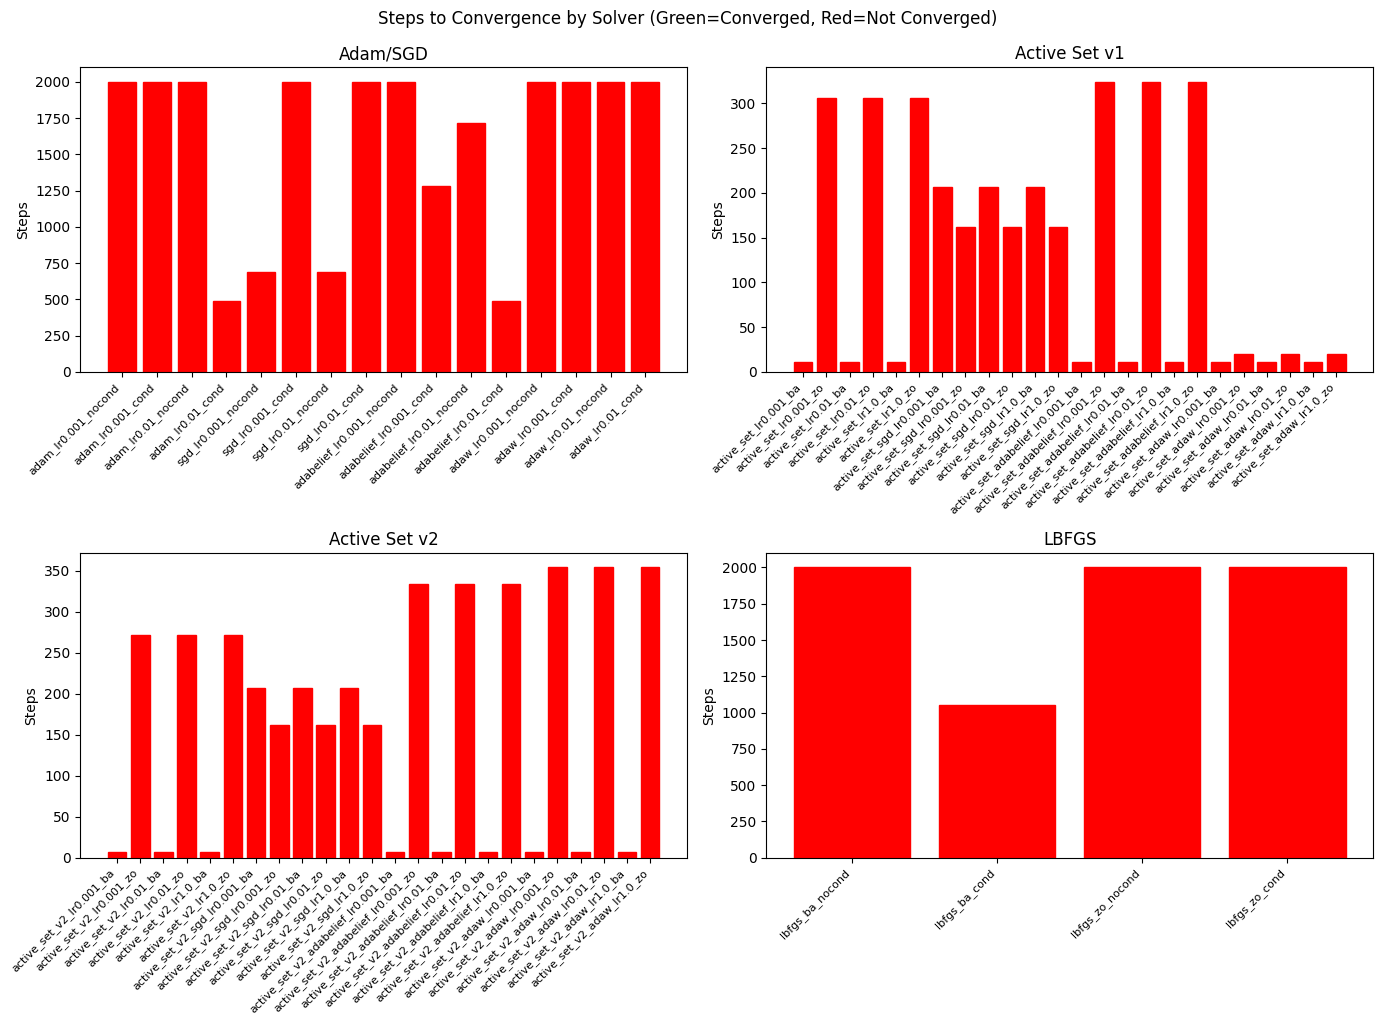

In [8]:
# Visualization: Steps comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categories = df["category"].unique()
colors = plt.cm.tab10.colors

for ax, category in zip(axes.flat, categories):
    cat_df = df[df["category"] == category]
    cat_df_valid = cat_df[cat_df["steps"] > 0]

    if len(cat_df_valid) > 0:
        bars = ax.bar(range(len(cat_df_valid)), cat_df_valid["steps"].values)
        ax.set_xticks(range(len(cat_df_valid)))
        ax.set_xticklabels(cat_df_valid["name"].values, rotation=45, ha="right", fontsize=8)

        # Color by convergence
        for bar, converged in zip(bars, cat_df_valid["converged"].values):
            bar.set_color("green" if converged else "red")

    ax.set_title(category)
    ax.set_ylabel("Steps")

plt.tight_layout()
plt.suptitle("Steps to Convergence by Solver (Green=Converged, Red=Not Converged)", y=1.02)
plt.show()

([<matplotlib.axis.XTick at 0x7f8a5022f990>,
 [Text(0, 0, 'scipy_cobyqa'),
  Text(1, 0, 'scipy_tnc'),
  Text(2, 0, 'adam_lr0.01_cond'),
  Text(3, 0, 'adabelief_lr0.01_nocond'),
  Text(4, 0, 'active_set_sgd_lr0.001_zo'),
  Text(5, 0, 'active_set_sgd_lr0.01_zo'),
  Text(6, 0, 'active_set_sgd_lr1.0_zo'),
  Text(7, 0, 'active_set_v2_sgd_lr0.001_zo'),
  Text(8, 0, 'active_set_v2_sgd_lr0.01_zo'),
  Text(9, 0, 'active_set_v2_sgd_lr1.0_zo')])

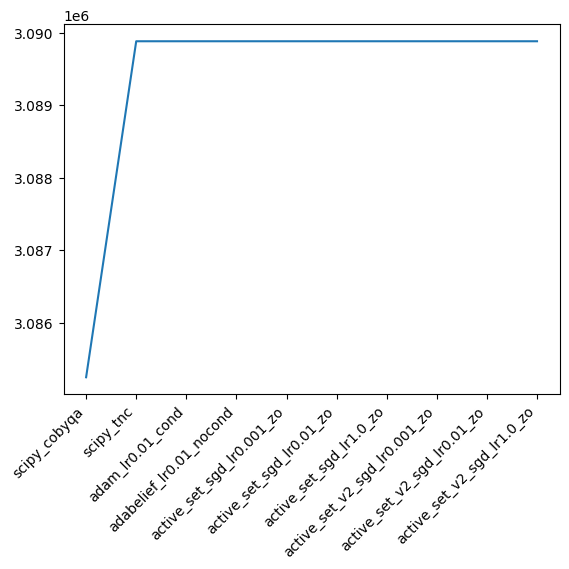

In [9]:
sorted_args = jnp.argsort(df["final_loss"].values)
sorted_f = df["final_loss"].values[sorted_args][:10]
sorted_names = df["name"].values[sorted_args][:10]
plt.plot(sorted_f)
plt.xticks(ticks=range(len(sorted_names)), labels=sorted_names, rotation=45, ha="right")

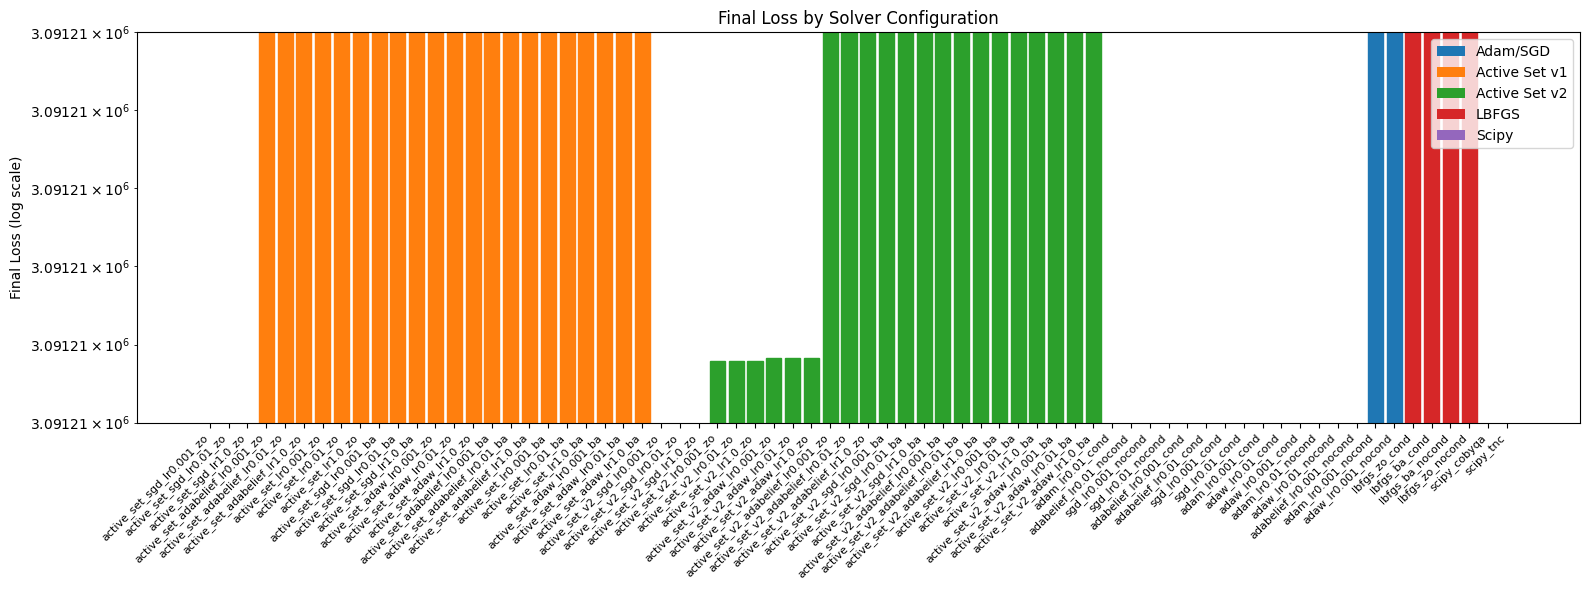

In [45]:
# Visualization: Final loss comparison (log scale)
fig, ax = plt.subplots(figsize=(16, 6))

df_valid = df[df["steps"] > 0].copy()
df_valid = df_valid.sort_values(["category", "final_loss"])

# Create grouped bar chart
x = range(len(df_valid))
bars = ax.bar(x, df_valid["final_loss"].values)

# Color by category
category_colors = {cat: colors[i] for i, cat in enumerate(categories)}
for bar, cat in zip(bars, df_valid["category"].values):
    bar.set_color(category_colors[cat])

ax.set_yscale("log")
ax.set_xticks(x)
ax.set_xticklabels(df_valid["name"].values, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("Final Loss (log scale)")
ax.set_title("Final Loss by Solver Configuration")
ax.axhline(y=1e-10, color="black", linestyle="--", label="Convergence threshold")
ax.set_ylim(3.0912078e6, 3.09120785e6)
# Add legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=category_colors[cat], label=cat) for cat in categories]
ax.legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

In [11]:
# Best performers per category
print("\n" + "=" * 60)
print(" Best Performer per Category")
print("=" * 60)

for category in categories:
    cat_df = df[(df["category"] == category) & (df["steps"] > 0)]
    if len(cat_df) > 0:
        # Best by final loss
        best = cat_df.loc[cat_df["final_loss"].idxmin()]
        print(f"\n{category}:")
        print(f"  Best by loss: {best['name']}")
        print(
            f"    - Steps: {best['steps']}, Loss: {best['final_loss']:.2e}, Dist: {best['distance_to_opt']:.2e}"
        )

        # Best by steps (among converged)
        converged = cat_df[cat_df["converged"]]
        if len(converged) > 0:
            fastest = converged.loc[converged["steps"].idxmin()]
            print(f"  Fastest converged: {fastest['name']}")
            print(f"    - Steps: {fastest['steps']}, Loss: {fastest['final_loss']:.2e}")


 Best Performer per Category

Adam/SGD:
  Best by loss: adam_lr0.01_cond
    - Steps: 488, Loss: 3.09e+06, Dist: 1.30e+01

Active Set v1:
  Best by loss: active_set_sgd_lr0.001_zo
    - Steps: 162, Loss: 3.09e+06, Dist: 1.30e+01

Active Set v2:
  Best by loss: active_set_v2_sgd_lr0.001_zo
    - Steps: 162, Loss: 3.09e+06, Dist: 1.30e+01

LBFGS:
  Best by loss: lbfgs_zo_cond
    - Steps: 2000, Loss: 3.09e+06, Dist: 1.29e+01

Scipy:
  Best by loss: scipy_cobyqa
    - Steps: 246, Loss: 3.09e+06, Dist: 1.41e+01


In [12]:
# Active Set v1 vs v2 comparison
# print("\n" + "="*60)
# print(" Active Set v1 vs v2 Comparison")
# print("="*60)
#
# v1_df = df[df["category"] == "Active Set v1"][["name", "steps", "final_loss", "converged"]].reset_index(drop=True)
# v2_df = df[df["category"] == "Active Set v2"][["name", "steps", "final_loss", "converged"]].reset_index(drop=True)
#
## Create side-by-side comparison
# comparison = pd.DataFrame({
#    "v1_name": v1_df["name"],
#    "v1_steps": v1_df["steps"],
#    "v1_loss": v1_df["final_loss"].apply(lambda x: f"{x:.2e}"),
#    "v2_name": v2_df["name"],
#    "v2_steps": v2_df["steps"],
#    "v2_loss": v2_df["final_loss"].apply(lambda x: f"{x:.2e}"),
# })
#
# print(comparison.to_string(index=False))


 Active Set v1 vs v2 Comparison
                        v1_name  v1_steps  v1_loss                            v2_name  v2_steps  v2_loss
          active_set_lr0.001_ba        11 3.10e+06           active_set_v2_lr0.001_ba         7 3.13e+06
          active_set_lr0.001_zo       306 3.10e+06           active_set_v2_lr0.001_zo       271 3.09e+06
           active_set_lr0.01_ba        11 3.10e+06            active_set_v2_lr0.01_ba         7 3.13e+06
           active_set_lr0.01_zo       306 3.10e+06            active_set_v2_lr0.01_zo       271 3.09e+06
            active_set_lr1.0_ba        11 3.10e+06             active_set_v2_lr1.0_ba         7 3.13e+06
            active_set_lr1.0_zo       306 3.10e+06             active_set_v2_lr1.0_zo       271 3.09e+06
      active_set_sgd_lr0.001_ba       207 3.10e+06       active_set_v2_sgd_lr0.001_ba       207 3.10e+06
      active_set_sgd_lr0.001_zo       162 3.09e+06       active_set_v2_sgd_lr0.001_zo       162 3.09e+06
       active_set_sgd_